In [1]:
import os
import subprocess
from pathlib import Path
from IPython import get_ipython
import re

In [2]:
!dir

 Volume in drive D is Samip
 Volume Serial Number is 3A4B-753D

 Directory of d:\Tesseract FineTuning\tesstrain

10/09/2024  07:47 PM    <DIR>          .
10/09/2024  07:47 PM    <DIR>          ..
10/09/2024  11:05 AM    <DIR>          .github
10/09/2024  11:05 AM                28 .gitignore
10/09/2024  11:05 AM               264 .pylintrc
10/09/2024  11:05 AM             1,634 count_chars.py
10/09/2024  07:33 PM    <DIR>          data
10/08/2024  06:59 PM           150,003 eval.ipynb
10/09/2024  11:05 AM             1,068 generate_eval_train.py
10/09/2024  11:05 AM             1,095 generate_gt_from_box.py
10/09/2024  11:05 AM             1,527 generate_line_box.py
10/09/2024  11:05 AM             2,336 generate_line_syllable_box.py
10/09/2024  11:05 AM             1,316 generate_wordstr_box.py
10/09/2024  11:05 AM            10,349 LICENSE
10/09/2024  11:05 AM            17,854 Makefile
10/09/2024  11:05 AM             1,385 normalize.py
10/09/2024  11:05 AM         5,524,523 ocrd-te

### Get number of checkpoints

In [13]:
# Get number of checkpoints
def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    if not folder.is_dir():
        raise ValueError(f"{folder_path} is not a valid directory")
    return len([f for f in folder.iterdir() if f.is_file()])

folder_path = r'D:\Tesseract FineTuning\tesstrain\data\sl7tech\tessdata_best'
counter=count_files_in_folder(folder_path)
print(f"Number of files in {folder_path}: {counter}")

Number of files in D:\Tesseract FineTuning\tesstrain\data\sl7tech\tessdata_best: 16


Automated script to evaluate each checkpoint and store error

In [14]:
#Automate the process

# Define your cell content as strings
cell_1_code = """
command = ['make', 'evaluation', 'MODEL_NAME=sl7tech']

output_lines=[]
# Run the command and print output in real-time
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, encoding='utf-8')

# Print the output line by line
for line in process.stdout:
    print(line, end='')
    output_lines.append(line)

# Wait for the process to complete and get the return code
process.wait()
print(f"Process finished with return code {process.returncode}")
output = ''.join(output_lines)
"""

cell_2_code = """
pattern = r'(time[\s\S]+?)(?=make)'

match = re.search(pattern,output)

if match:
    extracted_command = match.group(0)
    print("Extracted Command:")
    print(extracted_command)

    # Path to Git Bash
    git_bash_path = "C:/Program Files/Git/bin/bash.exe"

    # Run the command using subprocess
    try:
        process = subprocess.Popen([git_bash_path, '-c', extracted_command], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, encoding='utf-8')

        # Print the output line by line
        for line in process.stdout:
            print(line, end='')

        # Print any errors
        for line in process.stderr:
            print(line, end='')

        # Wait for the process to complete and get the return code
        process.wait()
        print(f"Process finished with return code {process.returncode}")

    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("Command not found in the output.")
"""

# Get the current IPython instance
ipython = get_ipython()

# Loop to run these cells multiple times
for i in range(counter):
    print(f"Iteration {i+1}: Running cells")
    ipython.run_cell(cell_1_code)
    ipython.run_cell(cell_2_code)

Iteration 1: Running cells
You are using make version: 4.4.1
time -p lstmeval  \
	--verbosity=0 \
	--model data/sl7tech/tessdata_best/sl7tech_2.364_1212_2500.traineddata \
	--eval_listfile data/sl7tech/list.eval 2>&1 | grep "^BCER eval" > data/sl7tech/eval/sl7tech_2.364_1212_2500.eval.log
make: *** [Makefile:359: data/sl7tech/eval/sl7tech_2.364_1212_2500.eval.log] Error 1
Process finished with return code 2
Extracted Command:
time -p lstmeval  \
	--verbosity=0 \
	--model data/sl7tech/tessdata_best/sl7tech_2.364_1212_2500.traineddata \
	--eval_listfile data/sl7tech/list.eval 2>&1 | grep "^BCER eval" > data/sl7tech/eval/sl7tech_2.364_1212_2500.eval.log

real 5.37
user 0.00
sys 0.00
Process finished with return code 0
Iteration 2: Running cells
You are using make version: 4.4.1
time -p lstmeval  \
	--verbosity=0 \
	--model data/sl7tech/tessdata_best/sl7tech_2.489_1131_2300.traineddata \
	--eval_listfile data/sl7tech/list.eval 2>&1 | grep "^BCER eval" > data/sl7tech/eval/sl7tech_2.489_1131

## Training and Eval Error Plot


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def read_eval_error(log_folder, metric):
    iterations = []
    errors = []
    for log_file in os.listdir(log_folder):
        if log_file.endswith('.eval.log'):
            iteration = int(re.search(r'_(\d+)\.eval\.log', log_file).group(1))
            with open(os.path.join(log_folder, log_file), 'r') as file:
                for line in file:
                    regex = rf'{metric} eval=([\d.]+)'
                    match = re.search(regex, line)
                    if match:
                        iterations.append(iteration)
                        errors.append(float(match.group(1)))
                        break
    return pd.DataFrame({'Iteration': iterations, 'Eval Error': errors})

In [17]:
def read_training_error(log_file, metric):
    iterations = []
    errors = []
    with open(log_file, 'r') as file:
        for line in file:
            regex = rf'At iteration \d+/\d+/(\d+), .* {metric} train=([\d.]+)%'
            match = re.search(regex, line)
            if match:
                iterations.append(int(match.group(1)))
                errors.append(float(match.group(2)))
    return pd.DataFrame({'Iteration': iterations, 'Training Error': errors})

In [18]:
model_name='sl7tech'
training_cer = read_training_error(f'data/{model_name}/training.log','BCER')
training_wer = read_training_error(f'data/{model_name}/training.log','BWER')

In [19]:
eval_cer = read_eval_error(f'data/{model_name}/eval', 'BCER')
eval_wer = read_eval_error(f'data/{model_name}/eval', 'BWER')

In [20]:
eval_cer

,Iteration,Eval Error
0,2500,2.495
1,2300,2.826
2,2100,2.653
3,1900,2.843
4,1600,3.036
5,1500,2.834
6,1300,2.922
7,1200,2.987
8,1100,2.903
9,1000,3.218


In [21]:
char_data = pd.merge(training_cer, eval_cer, on='Iteration', how='inner').sort_values(by='Iteration')
char_data

,Iteration,Training Error,Eval Error
0,100,6.699,5.829
1,400,5.769,3.608
2,500,5.531,3.189
3,600,5.394,3.338
4,700,5.046,3.475
5,800,4.815,2.905
6,1000,4.488,3.218
7,1100,4.071,2.903
8,1200,3.698,2.987
9,1300,3.378,2.922


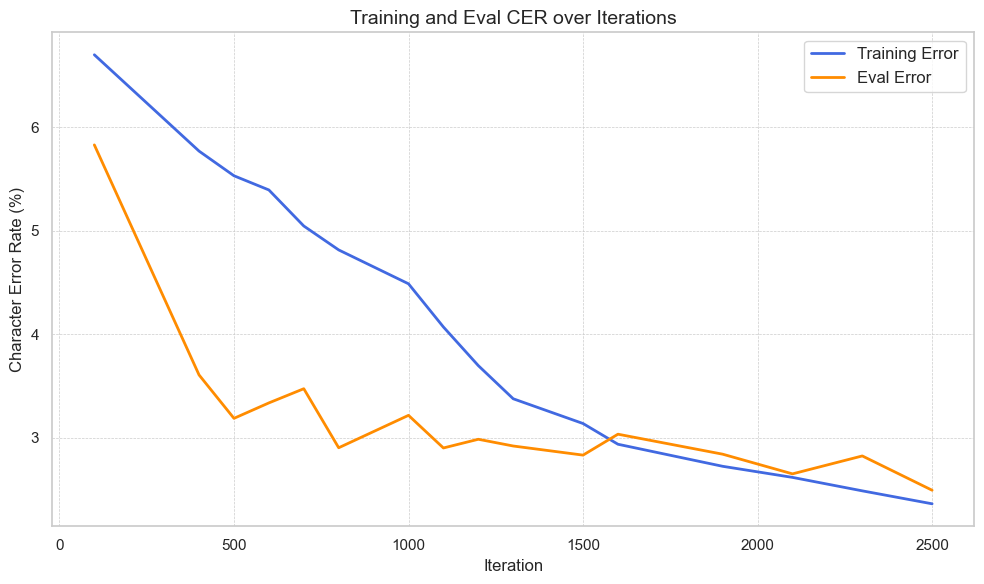

In [22]:
import seaborn as sns

filtered_data=char_data

# Set seaborn style for a cleaner look
sns.set_theme(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))  # Slightly wider figure for better readability

# Plot training and Eval error with thicker lines and custom colors
plt.plot(filtered_data['Iteration'], filtered_data['Training Error'], label='Training Error', color='royalblue', linewidth=2)
plt.plot(filtered_data['Iteration'], filtered_data['Eval Error'], label='Eval Error', color='darkorange', linewidth=2)

# Labels and title
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Character Error Rate (%)', fontsize=12)
plt.title('Training and Eval CER over Iterations', fontsize=14)

# Legend with improved font size
plt.legend(fontsize=12)

# Grid lines with a light touch
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure a clean layout
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
word_data = pd.merge(training_wer, eval_wer, on='Iteration', how='inner').sort_values(by='Iteration')
word_data

,Iteration,Training Error,Eval Error
0,100,18.264,15.031
1,400,14.100,8.678
2,500,13.665,9.192
3,600,13.006,9.428
4,700,12.276,9.579
5,800,11.779,9.257
6,1000,11.062,9.579
7,1100,9.971,8.742
8,1200,9.246,9.643
9,1300,8.551,8.292


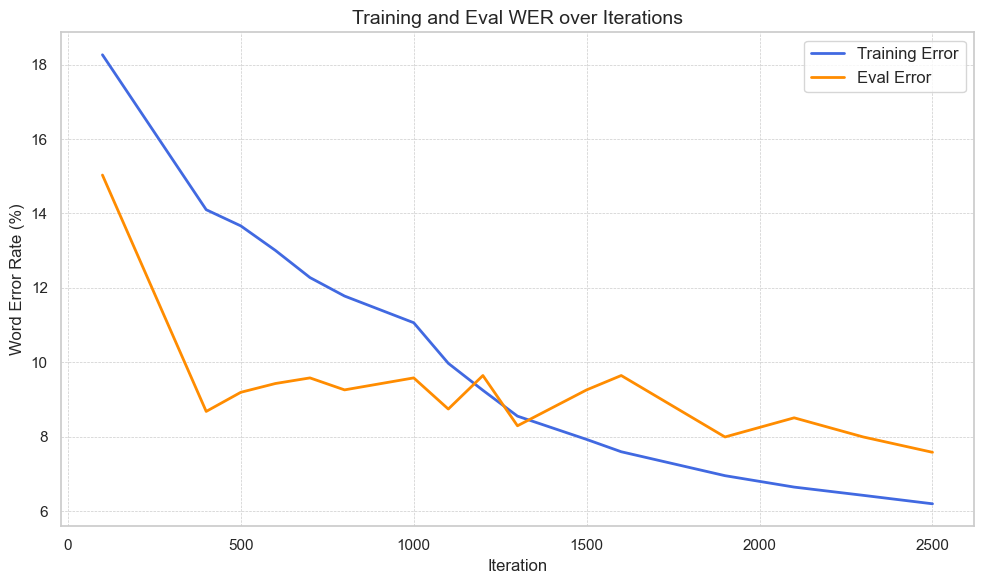

In [24]:
filtered_data=word_data

# Set seaborn style for a cleaner look
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))  # Slightly wider figure for better readability

# Plot training and Eval error with thicker lines and custom colors
plt.plot(filtered_data['Iteration'], filtered_data['Training Error'], label='Training Error', color='royalblue', linewidth=2)
plt.plot(filtered_data['Iteration'], filtered_data['Eval Error'], label='Eval Error', color='darkorange', linewidth=2)

# Labels and title
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Word Error Rate (%)', fontsize=12)
plt.title('Training and Eval WER over Iterations', fontsize=14)

# Legend with improved font size
plt.legend(fontsize=12)

# Grid lines with a light touch
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure a clean layout
plt.tight_layout()

# Display the plot
plt.show()

In [3]:
import pytesseract
from PIL import Image

image=Image.open(r'data\sl7tech-ground-truth\alexis_ruhe01_1852_0018_022.tif')
text=pytesseract.image_to_string(image,lang='sl7tech')
print(text)

ich denke. Aber was die ſelige Frau Geheimräthin

